In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#### **Import Package**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.models import Sequential,load_model
from keras.optimizers import Adam
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

#### **Read Data**

In [ ]:
def convert_to_date(x):
  return datetime.strptime(x, '%Y %m %d %H')

In [ ]:
np.set_printoptions(suppress=True)
sales_df = pd.read_csv('Sample - Superstore.csv', encoding='latin-1')
sales_df.head(n=4)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2014-103800,1/3/2014,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,740,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2,741,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
3,742,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870


#### **Preprocessing Data**

##### **Summarizing Data**

In [ ]:
sales_df.isnull()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9990,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
sales_df.info()
print("Jumlah duplikasi data: ", sales_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [ ]:
sales_df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [ ]:
print ('Data rows        : ', sales_df.shape[0])
print ('Data columns     : ', sales_df.shape[1])
print ('Features         :', sales_df.columns.tolist())
print ('\nMissing values :', sales_df.isnull().sum())
print ('\nUnique values  :', sales_df.nunique())

Data rows        :  9994
Data columns     :  21
Features         : ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Missing values : Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Unique values  : Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State

##### **Feature Engineering**

In [ ]:
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], errors='coerce')

def get_month(inpDate):
    return inpDate.month

def get_year(inpDate):
    return inpDate.year

sales_df['Month'] = sales_df['Order Date'].apply(get_month)
sales_df['Year'] = sales_df['Order Date'].apply(get_year)

sales_df.head(n=5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Month,Year
0,7981,CA-2014-103800,2014-01-03,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,1,2014
1,740,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,1,2014
2,741,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,1,2014
3,742,CA-2014-112326,2014-01-04,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,1,2014
4,1760,CA-2014-141817,2014-01-05,1/12/2014,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,1,2014


In [ ]:
print('Variasi nilai tahun pada data : ', sales_df['Year'].sort_values().nunique())
print('Variasi nilai bulan pada data : ', sales_df['Month'].sort_values().nunique())

Variasi nilai tahun pada data :  4
Variasi nilai bulan pada data :  12



##### **Aggregating Sales Quantity**

In [ ]:
pd.crosstab(columns = sales_df['Month'],
            index   = sales_df['Year'],
            values  = sales_df['Quantity'],
            aggfunc='sum')

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2014,284,159,585,536,466,521,550,609,1000,573,1219,1079
2015,236,239,515,543,575,486,557,598,1086,631,1310,1203
2016,358,306,579,635,863,742,758,693,1316,767,1406,1414
2017,597,363,885,733,887,931,840,884,1660,1133,1840,1723


##### **Visualizing Sales Quantity**

In [ ]:
sales_qt = pd.crosstab(
    columns=sales_df['Year'],
    index=sales_df['Month'],
    values=sales_df['Quantity'],
    aggfunc='sum'
).reset_index().melt(id_vars='Month', var_name='Year', value_name='Quantity')

sales_qt_df = pd.DataFrame(sales_qt)

sales_qt_df = sales_qt_df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
sales_qt_df['Date'] = sales_qt_df['Month'].astype(str).str.zfill(2) + '-' + sales_qt_df['Year'].astype(str)
columns_order = ['Date'] + [col for col in sales_qt_df.columns if col != 'Date']
sales_qt_df = sales_qt_df[columns_order]

In [ ]:
sales_qt_df = sales_qt_df.drop(columns=['Year', 'Month'])
sales_qt_df.head()

,Date,Quantity
0,01-2014,284
1,02-2014,159
2,03-2014,585
3,04-2014,536
4,05-2014,466


In [ ]:
fig = px.line(sales_qt_df, x='Date', y='Quantity', title='Sales Quantity')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=2, label='2y', step='year', stepmode='backward'),
            dict(count=3, label='3y', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)
fig.show()

##### **Decomposing Sales Quantity**

<Figure size 1600x500 with 0 Axes>

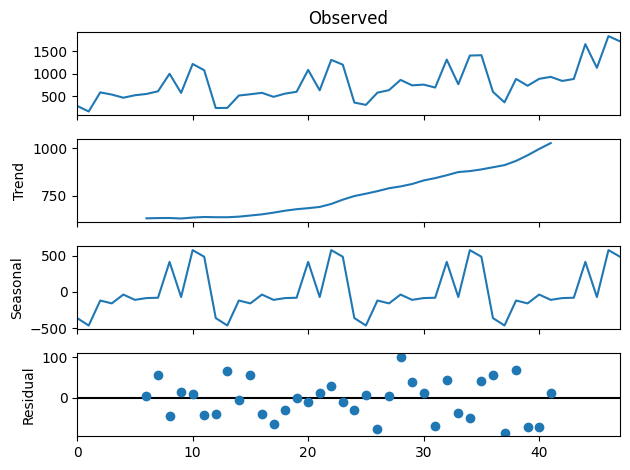

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = sales_qt_df['Quantity'].values
result = seasonal_decompose(series, period = 12)
plt.figure(figsize=(16, 5))
result.plot()
plt.show()

##### **Check for Stationary Data**

###### **AC and PAC Function**

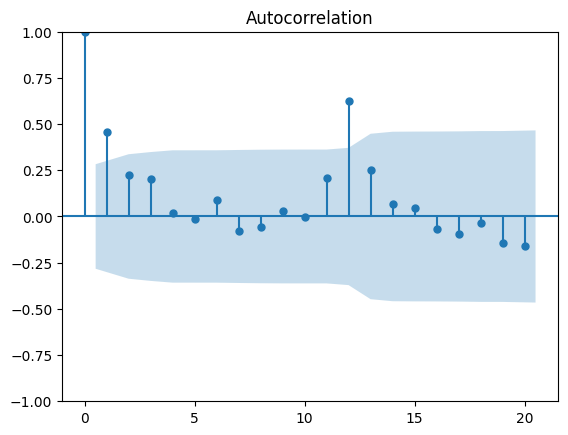

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original  = plot_acf(sales_qt_df['Quantity'], lags=20)

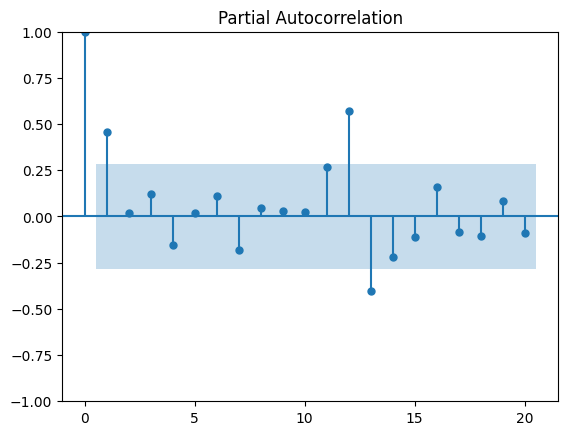

In [ ]:
pacf_original = plot_pacf(sales_qt_df['Quantity'], lags=20)

###### **Adfuller Test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
df_test = adfuller(sales_qt_df['Quantity'], autolag='AIC')

print('ADF Statistic: %f' % df_test[0])
print('p-value: %f' % df_test[1])
print('Num of lags: %i' % df_test[2])
print('Num of observations used for ADF regression and critical values calculation: %f' % df_test[3])
print('Critical Values:')
for key, value in df_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.551070
p-value: 0.006768
Num of lags: 0
Num of observations used for ADF regression and critical values calculation: 47.000000
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


In [ ]:
from statsmodels.tsa.stattools import adfuller

def tes_stasioner(data):
    df = adfuller(data, autolag='AIC')

    adf_stat = df[0]
    p_value = df[1]
    critical_values = df[4]

    if p_value <= 0.05:
      print("Data stasioner")
    else:
      print("Data tidak stasioner")

    print('ADF Statistic: %f' % df[0])
    print('p-value: %f' % df[1])
    for key, value in df[4].items():
        print('\t%s: %.3f' % (key, value))


In [ ]:
tes_stasioner(sales_qt_df['Quantity'])

Data stasioner
ADF Statistic: -3.551070
p-value: 0.006768
	1%: -3.578
	5%: -2.925
	10%: -2.601


#### **ARIMA Model**

##### **Training ARIMA Model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
arima_model = ARIMA(sales_qt_df['Quantity'],
                        order = (12, 0, 4))

arima_model = arima_model.fit()

##### **Visualizing the Final Result**

Next Six Month Forecast:
 48     890.154915
49     569.318259
50     946.910210
51     748.140607
52     888.096047
53     856.858814
54     727.665883
55     757.462647
56    1467.222649
57    1006.433195
58    1668.697724
59    1631.645036
Name: Predicted Value, dtype: float64

Model Accuracy       :  76.08
MAE                  :  125.05
MSE                  :  31391.5
R² Score             :  0.802


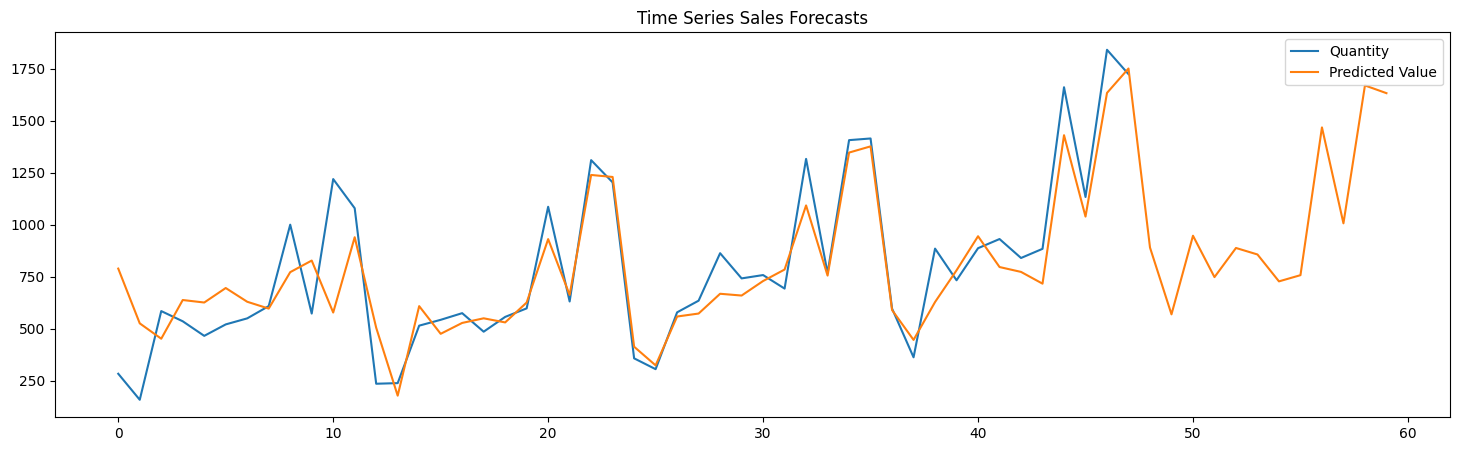

In [ ]:
FutureMonths = 12
forecast = arima_model.predict(start=0,
                          end=len(sales_qt_df['Quantity']) + FutureMonths - 1,
                          typ='levels').rename('Predicted Value')

print("Next Six Month Forecast:\n",forecast[-FutureMonths:])
sales_qt_df['Quantity'].plot(figsize=(18, 5), legend=True, title='Time Series Sales Forecasts')
forecast.plot(legend=True, figsize=(18, 5))

actual = sales_qt_df['Quantity']
forecast_actual = forecast[:len(actual)]

MAPE = np.mean(abs(actual - forecast_actual) / actual) * 100
print('\nModel Accuracy       : ', round(100 - MAPE, 2))
MAE = mean_absolute_error(actual, forecast_actual)
print('MAE                  : ', round(MAE, 2))
MSE = mean_squared_error(actual, forecast_actual)
print('MSE                  : ', round(MSE, 2))
R2_Score = r2_score(actual, forecast_actual)
print('R² Score             : ', round(R2_Score, 3))

#### **SARIMA Model**

##### **Training SARIMA Model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
sarima_model = SARIMAX(sales_qt_df['Quantity'],
                        order = (1, 0, 4),
                        seasonal_order =(1, 0, 0, 12))

sales_model = sarima_model.fit(disp=False)

##### **Visualizing Final Result**

Next Six Month Forecast:
 49     661.343467
50    1116.811482
51     972.656872
52    1114.351105
53    1149.596070
54    1054.141463
55    1089.813777
56    1835.548333
57    1317.895458
58    1997.108167
59    1877.432853
60    1085.896852
Name: Predicted Value, dtype: float64

Model Accuracy       :  81.02
MAE                  :  118.97
MSE                  :  31783.19
R² Score             :  0.799


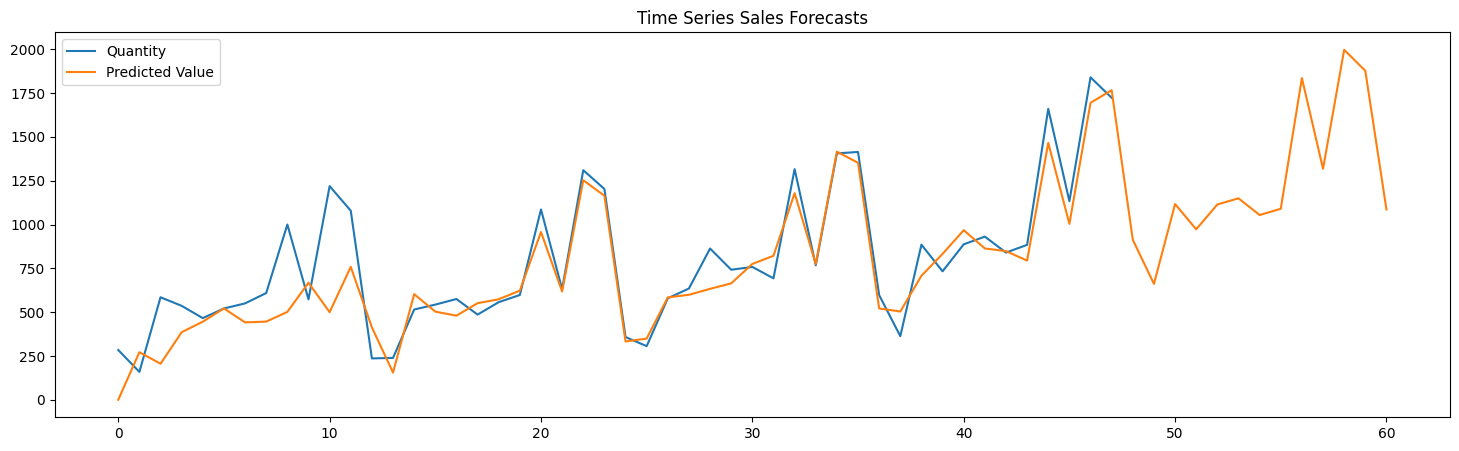

In [ ]:
print("Next Six Month Forecast:\n", forecast[-FutureMonths:])

sales_qt_df['Quantity'].plot(figsize=(18, 5), legend=True, title='Time Series Sales Forecasts')
forecast.plot(legend=True, figsize=(18, 5))

pred_val = sales_model.fittedvalues
actual = sales_qt_df['Quantity']

MAPE = mean_absolute_percentage_error(actual, pred_val) * 100
print('\nModel Accuracy       : ', round(100 - MAPE, 2))

MAE = mean_absolute_error(actual, pred_val)
print('MAE                  : ', round(MAE, 2))

MSE = mean_squared_error(actual, pred_val)
print('MSE                  : ', round(MSE, 2))

R2_Score = r2_score(actual, pred_val)
print('R² Score             : ', round(R2_Score, 3))

#### **Exponential Smoothing**

##### **Tunning Parameters**

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
warnings.filterwarnings('ignore')

def tune_ets(inpData, trend_values, seasonal_values, seasonal_periods):
    results = pd.DataFrame()

    for trend in trend_values:
        for seasonal in seasonal_values:
            for period in seasonal_periods:
                try:
                    from statsmodels.tsa.api import ExponentialSmoothing
                    model = ExponentialSmoothing(
                        inpData,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=period
                    ).fit()

                    pred = model.fittedvalues
                    accuracy = 100 - np.mean(np.abs((inpData - pred) / inpData) * 100)

                    results = pd.concat([results, pd.DataFrame([[trend, seasonal, period, accuracy]],
                                                           columns=['trend', 'seasonal', 'seasonal_periods', 'accuracy'])])
                except Exception as e:
                    print(f"Error with parameters: trend={trend}, seasonal={seasonal}, period={period}")
                    print(e)

    return results

In [ ]:
result_data = tune_ets(
    inpData = sales_qt_df['Quantity'],
    trend_values=[None, 'add', 'mul'],
    seasonal_values=[None, 'add', 'mul'],
    seasonal_periods=[12]
)

##### **Parameter Selection**

In [ ]:
result_data_sorted = result_data.sort_values(by='accuracy', ascending=False).head(n=10)
result_data_sorted

,trend,seasonal,seasonal_periods,accuracy
0,add,add,12,91.905456
0,mul,add,12,91.875914
0,None,add,12,91.175808
0,add,mul,12,90.786407
0,mul,mul,12,90.759691
0,None,mul,12,90.316410
0,None,None,12,57.440609
0,add,None,12,57.216579
0,mul,None,12,47.684405


In [ ]:
best_params = result_data_sorted.iloc[0]

best_model = ExponentialSmoothing(
    sales_qt_df['Quantity'],
    trend=best_params['trend'],
    seasonal=best_params['seasonal'],
    seasonal_periods=best_params['seasonal_periods']
).fit()

predict_months = 12
forecast = best_model.forecast(steps=predict_months).rename('Forecast')
forecast_2 =  best_model.predict(start = 0,
                               end = (len(sales_qt_df) + predict_months)).rename('Forecast')
forecast_ets = best_model.predict(start = 0,
                                     end = len(sales_qt_df['Quantity'])-1)
print(f"Prediksi {predict_months} Bulan Kedepan: ", forecast_2[-predict_months:])

Prediksi 12 Bulan Kedepan:  49     822.535147
50    1222.432443
51    1218.079593
52    1327.880456
53    1323.069273
54    1351.658739
55    1393.558430
56    1984.190752
57    1514.366105
58    2201.431105
59    2130.765759
60    1314.391506
Name: Forecast, dtype: float64


##### **Visualizing the Final Result**

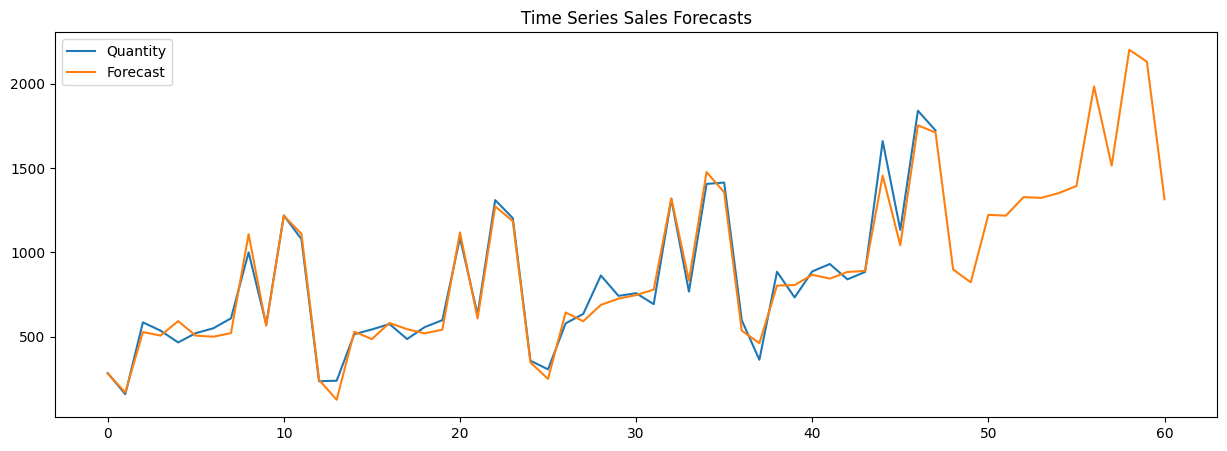


Model Accuracy       :  91.91
MAE                  :  52.35
MSE                  :  4669.77
R² Score             :  0.97


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
plt.figure(figsize=(15, 5))
sales_qt_df['Quantity'].plot(legend=True, title='Time Series Sales Forecasts')
forecast_2.plot(legend=True)
plt.show()

pred_val = best_model.fittedvalues
MAPE = mean_absolute_percentage_error(sales_qt_df['Quantity'], pred_val) * 100
print('\nModel Accuracy       : ', round(100 - MAPE, 2))
MAE = mean_absolute_error(sales_qt_df['Quantity'], pred_val)
print('MAE                  : ', round(MAE, 2))
MSE = mean_squared_error(sales_qt_df['Quantity'], pred_val)
print('MSE                  : ', round(MSE, 2))
R2_Score = r2_score(sales_qt_df['Quantity'], forecast_ets)
print('R² Score             : ', round(R2_Score, 3))

#### **Long Short Term Memory (LSTM)**

##### **Series to Supervised**

In [ ]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
sales_qt_df_values = sales_qt_df['Quantity'].values
n_steps = 3
X, y = split_sequence(sales_qt_df_values, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape, y.shape

((45, 3, 1), (45,))

##### **Build LSTM Model**

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=200, batch_size=16, verbose=0, validation_split=0.2)

##### **Train and Validation Lost**

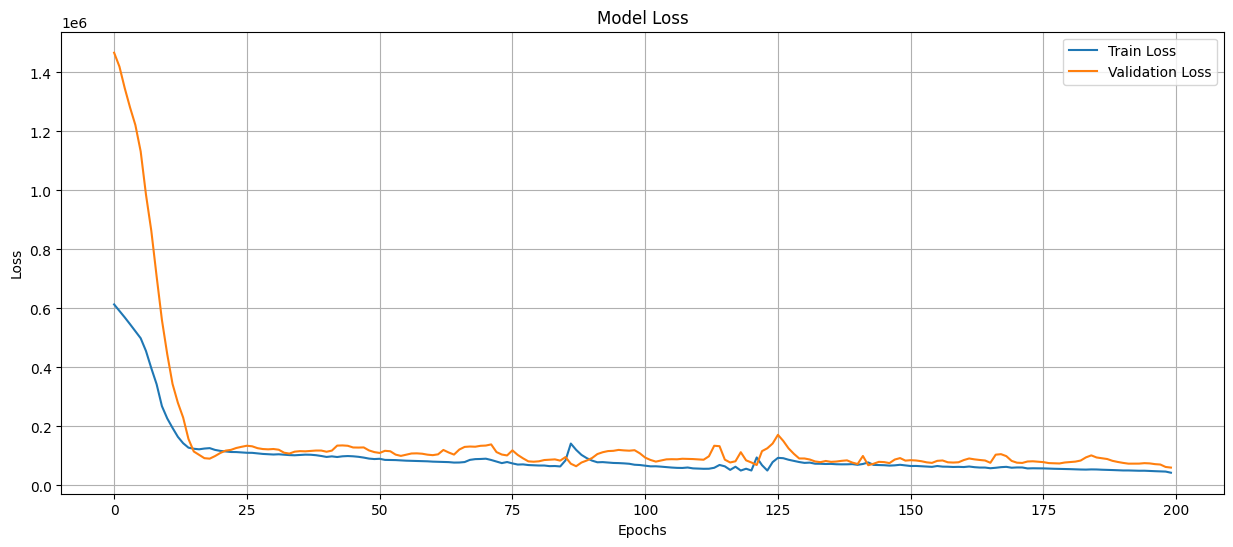

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

##### **Visualizing the Final Result**

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 895ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Model Accuracy:  79.18 %
MAE           :  134.31
LSTM R2 Score :  0.71


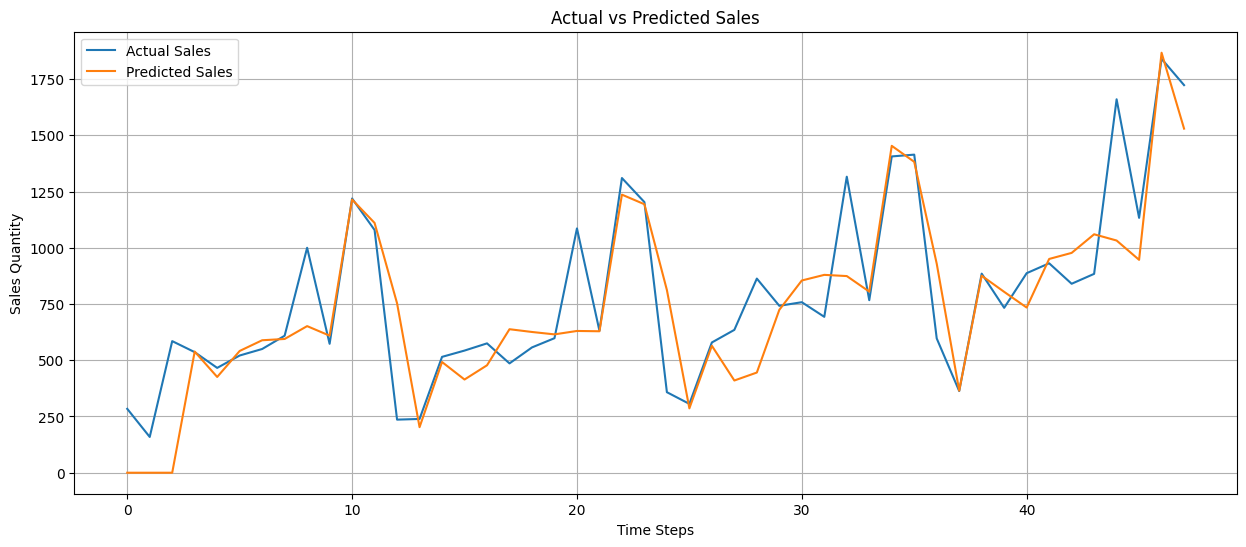

In [ ]:
data_pred = model.predict(X)

predicted_values = data_pred.flatten()

actual_values = sales_qt_df['Quantity'].values[n_steps:]
predicted_values_full = np.concatenate([np.zeros(n_steps), predicted_values])

data_pred = model.predict(X)

non_zero_idx = y != 0
MAPE = np.mean(abs(y - data_pred.squeeze()) / y) * 100
print('Model Accuracy: ', round(100 - MAPE, 2), '%')

MAE  = np.mean(abs(y - data_pred.squeeze()))
print ('MAE           : ', round(MAE, 2))

R2_Score = r2_score(y, data_pred.squeeze())
print('LSTM R2 Score : ', round(R2_Score, 2))

final_data = pd.DataFrame({
    'Actual': y.flatten(),
    'Predicted': data_pred.flatten()
})
plt.figure(figsize=(15, 6))
plt.plot(sales_qt_df['Quantity'], label='Actual Sales')
plt.plot(predicted_values_full, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Steps')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.show()